In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

In [27]:

df = pd.read_csv("cybersecurity_attacks.csv", parse_dates=['Timestamp'])


In [28]:

df.head().T

print("Dimension (No.of Rows, No.of Columns) of the Dataset: ", df.shape)
df.info()
df.describe().T


Dimension (No.of Rows, No.of Columns) of the Dataset:  (40000, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Timestamp               40000 non-null  datetime64[ns]
 1   Source IP Address       40000 non-null  object        
 2   Destination IP Address  40000 non-null  object        
 3   Source Port             40000 non-null  int64         
 4   Destination Port        40000 non-null  int64         
 5   Protocol                40000 non-null  object        
 6   Packet Length           40000 non-null  int64         
 7   Packet Type             40000 non-null  object        
 8   Traffic Type            40000 non-null  object        
 9   Payload Data            40000 non-null  object        
 10  Malware Indicators      20000 non-null  object        
 11  Anomaly Scores          40000 non-null 

,count,mean,min,25%,50%,75%,max,std
Timestamp,40000,2021-11-22 06:17:52.200800256,2020-01-01 00:43:27,2020-12-12 19:56:28.500000,2021-11-21 18:12:51,2022-10-30 08:48:10.500000,2023-10-11 19:34:23,NaN
Source Port,40000.0,32970.35645,1027.0,16850.75,32856.0,48928.25,65530.0,18560.425604
Destination Port,40000.0,33150.86865,1024.0,17094.75,33004.5,49287.0,65535.0,18574.668842
Packet Length,40000.0,781.452725,64.0,420.0,782.0,1143.0,1500.0,416.044192
Anomaly Scores,40000.0,50.113473,0.0,25.15,50.345,75.03,100.0,28.853598


Information on Frequncy of Attacks


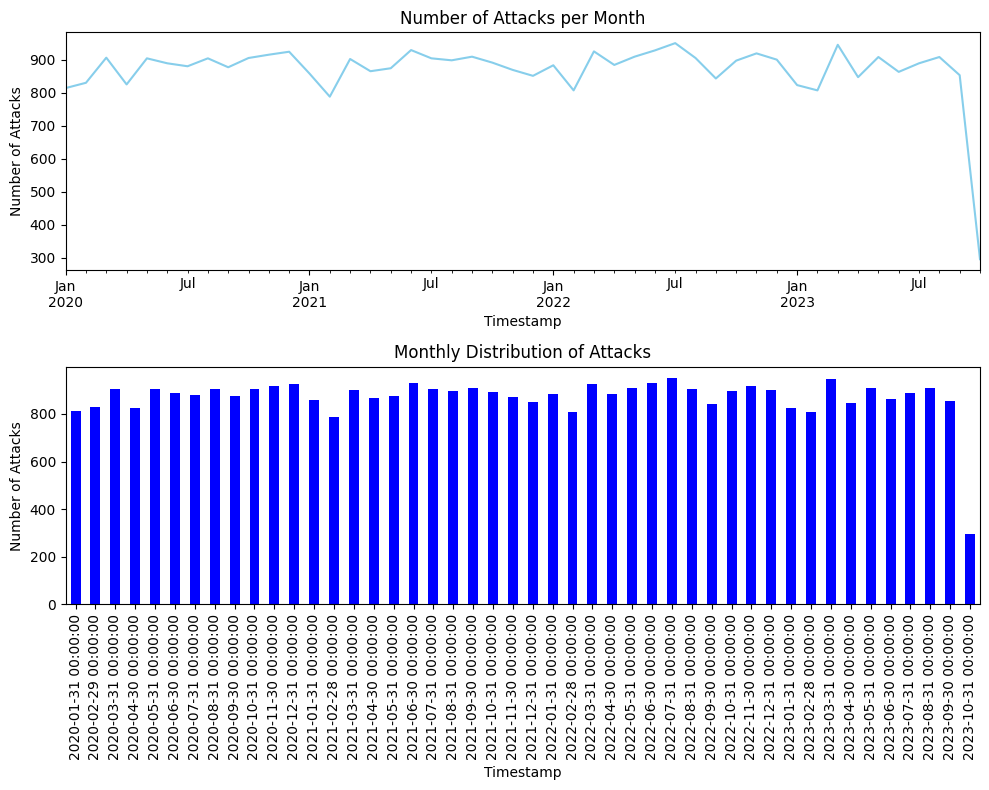

In [29]:

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
monthly_attacks = df.resample('ME', on='Timestamp')['Attack Type'].count()
print("Information on Frequncy of Attacks")
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
monthly_attacks.plot(ax=ax[0], color='skyblue')
ax[0].set_title('Number of Attacks per Month')
ax[0].set_ylabel('Number of Attacks')
monthly_attacks.plot(kind='bar', ax=ax[1], color='blue')
ax[1].set_title('Monthly Distribution of Attacks')
ax[1].set_ylabel('Number of Attacks')
plt.tight_layout()
plt.show()


Summary of the No.of Attacks Year wise
 Attack Type  DDoS  Intrusion  Malware
Year                                 
2020         3533       3551     3489
2021         3545       3475     3518
2022         3558       3563     3629
2023         2792       2676     2671


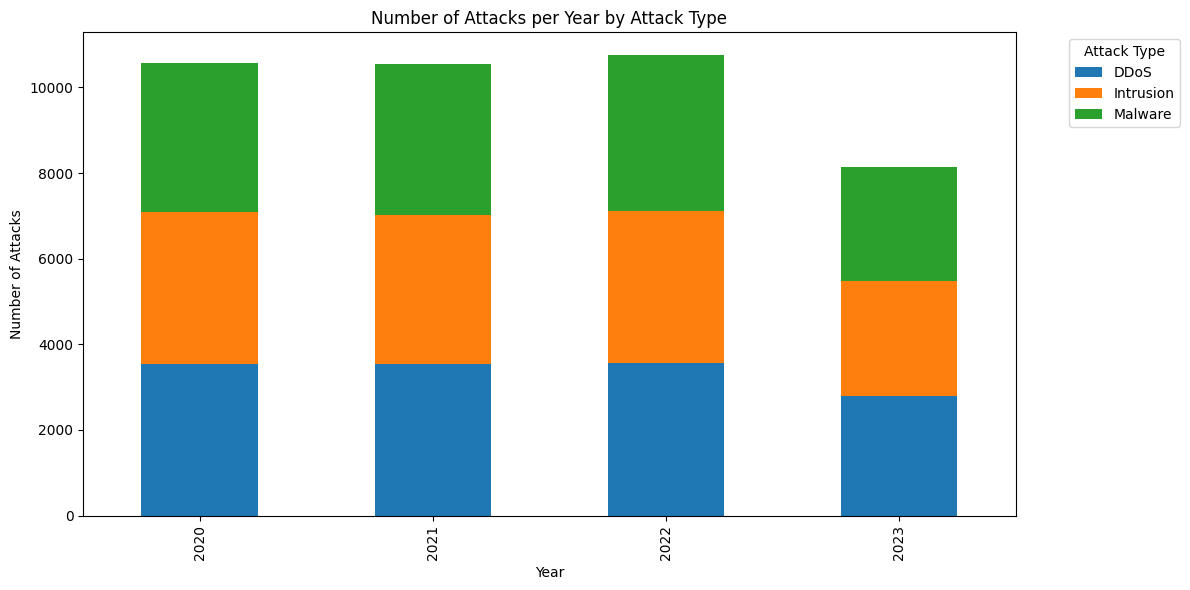

In [30]:

df['Year']=df['Timestamp'].dt.year
attack_counts = df.groupby(['Year', 'Attack Type']).size().unstack(fill_value=0)

print("Summary of the No.of Attacks Year wise\n",attack_counts)

ax = attack_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Number of Attacks per Year by Attack Type')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


In [31]:


protocol_attack_counts = df.groupby(['Protocol', 'Attack Type']).size().reset_index(name='COUNT')

top_10 = protocol_attack_counts.sort_values('COUNT', ascending=False).head(10)
print(top_10)



  Protocol Attack Type  COUNT
0     ICMP        DDoS   4508
6      UDP        DDoS   4482
2     ICMP     Malware   4461
1     ICMP   Intrusion   4460
3      TCP        DDoS   4438
5      TCP     Malware   4437
8      UDP     Malware   4409
7      UDP   Intrusion   4408
4      TCP   Intrusion   4397


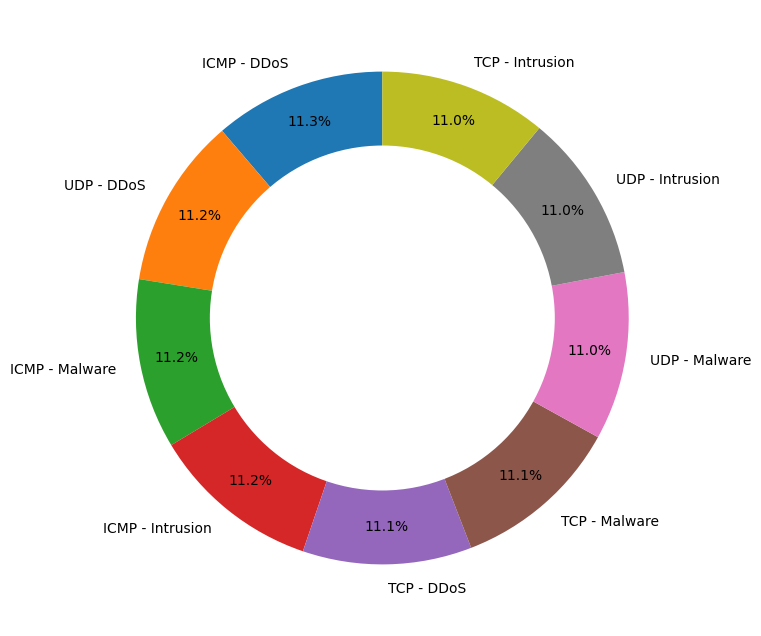

In [32]:

plt.figure(figsize=(12, 8)) 
plt.pie(
    top_10['COUNT'],
    labels=top_10.apply(lambda x: f"{x['Protocol']} - {x['Attack Type']}", axis=1),
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
)

center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
ax = plt.gca()
ax.add_artist(center_circle)



C:\Users\Karan\AppData\Local\Temp\ipykernel_14096\2261386173.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


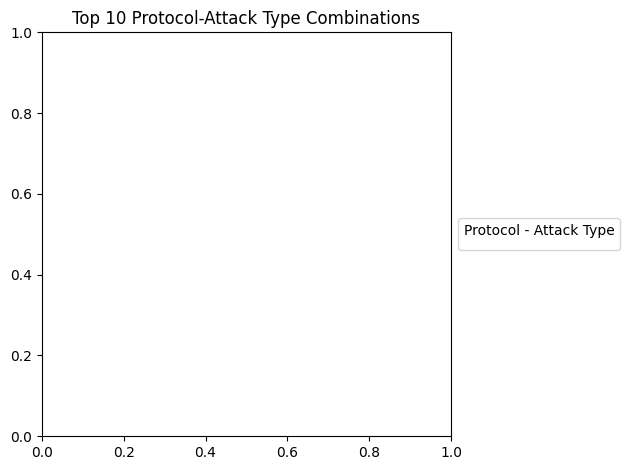

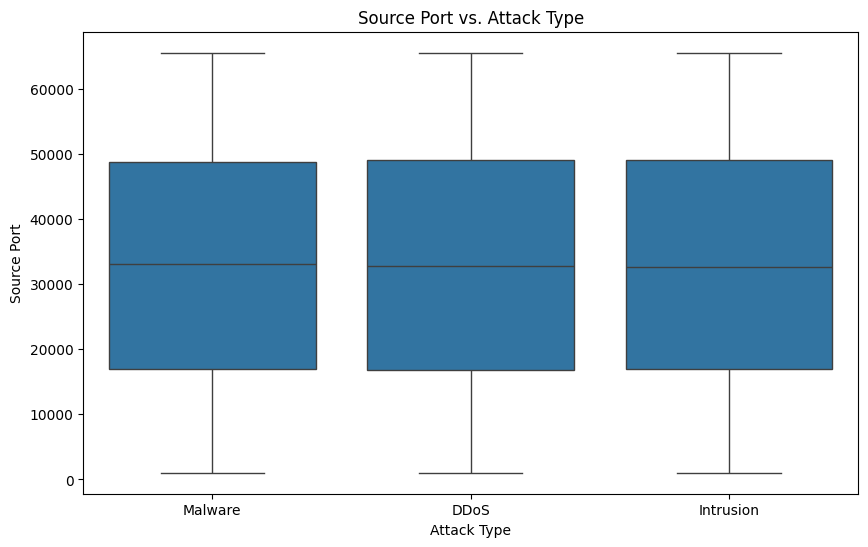

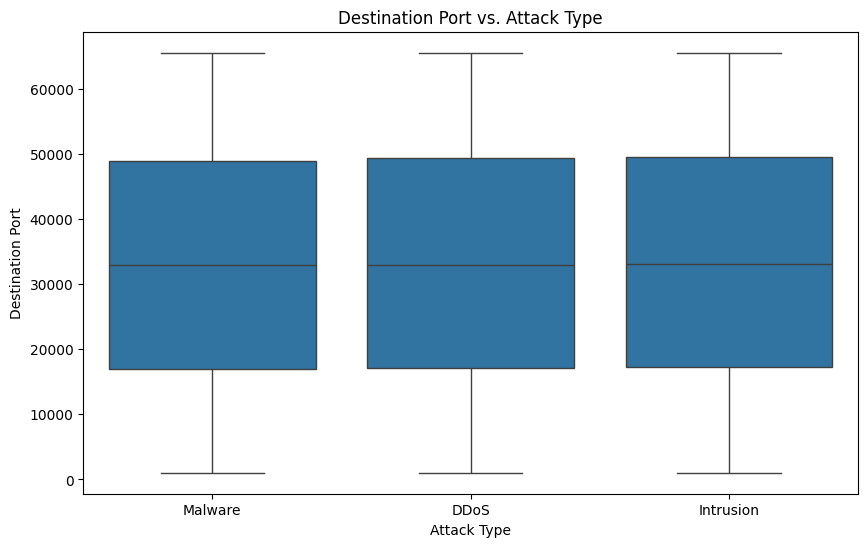

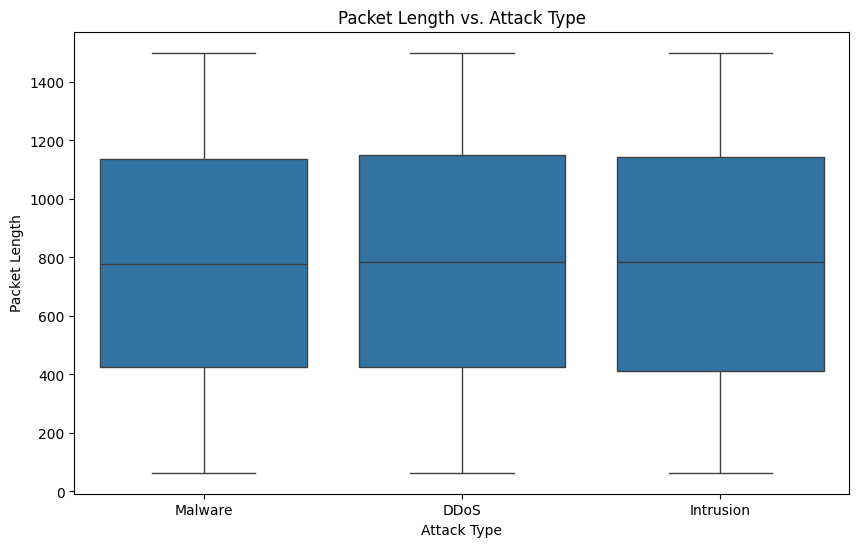

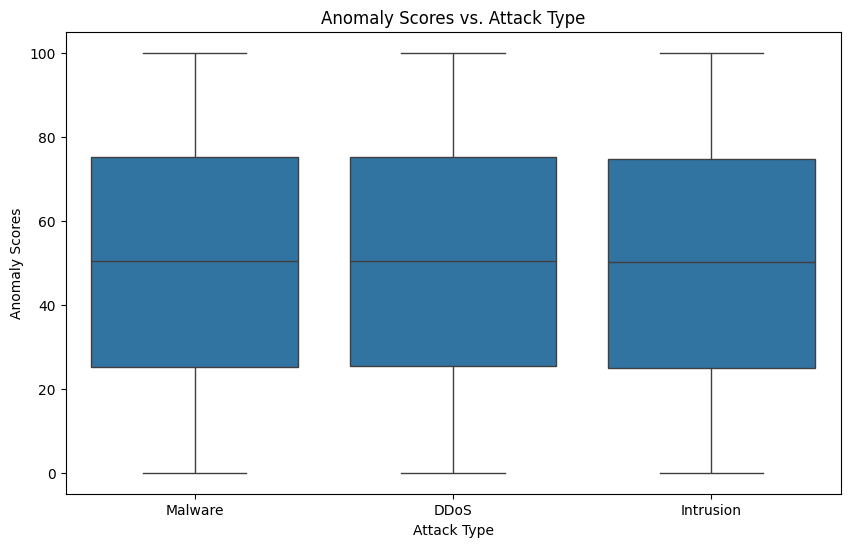

In [33]:

plt.title('Top 10 Protocol-Attack Type Combinations')
plt.legend(
    title='Protocol - Attack Type',
    loc='center left',
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.tight_layout()
plt.show()

features = ['Source Port', 'Destination Port', 'Packet Length', 'Anomaly Scores']
for feature in features:
    plt.figure(figsize=(10, 6)) 
    sns.boxplot(x='Attack Type', y=feature, data=df)  
    plt.title(f'{feature} vs. Attack Type') 
    plt.xlabel('Attack Type') 
    plt.ylabel(feature) 
    plt.show() 


In [34]:


columns_with_missing = df.columns[df.isnull().any()].tolist()

print("Columns with missing values:")
for column in columns_with_missing:
    print(column)

print("\nColumns with missing values and their counts:")
for column in columns_with_missing:
    missing_count = df[column].isnull().sum()
    print(f"{column}: {missing_count}")


df = df.fillna(0)


df.info()


Columns with missing values:
Malware Indicators
Alerts/Warnings
Proxy Information
Firewall Logs
IDS/IPS Alerts

Columns with missing values and their counts:
Malware Indicators: 20000
Alerts/Warnings: 20067
Proxy Information: 19851
Firewall Logs: 19961
IDS/IPS Alerts: 20050
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Timestamp               40000 non-null  datetime64[ns]
 1   Source IP Address       40000 non-null  object        
 2   Destination IP Address  40000 non-null  object        
 3   Source Port             40000 non-null  int64         
 4   Destination Port        40000 non-null  int64         
 5   Protocol                40000 non-null  object        
 6   Packet Length           40000 non-null  int64         
 7   Packet Type             40000 non-null  object        
 8   Traffic Typ

In [35]:

print("Timestamp values in YYYY-MM-DD HH:MM:SS format:\n", df['Timestamp'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %I:%M:%S %p')
df['Timestamp'] = df['Timestamp'].apply(lambda x: int(x.timestamp()))
print("Timestamp in UNIX Epoch format:\n", df['Timestamp'])

def ip_to_int(ip):
    return int(ipaddress.ip_address(ip))

df['Destination IP Address'] = df['Destination IP Address'].apply(ip_to_int)
df['Source IP Address'] = df['Source IP Address'].apply(ip_to_int)

df['Firewall Logs'] = df['Firewall Logs'].replace('Log Data', 1)
df['Malware Indicators'] = df['Malware Indicators'].replace('IoC Detected', 1)
df['Alerts/Warnings'] = df['Alerts/Warnings'].replace('Alert Triggered', 1)

df = df.drop(columns=['IDS/IPS Alerts', 'Proxy Information', 'Year'])

le = LabelEncoder()
categorical_columns = [
    'Attack Type', 'Log Source', 'Attack Signature', 'Action Taken', 
    'Severity Level', 'User Information', 'Device Information', 
    'Network Segment', 'Protocol', 'Geo-location Data', 
    'Packet Type', 'Traffic Type', 'Payload Data'
]

for column in categorical_columns:
    df[column] = le.fit_transform(df[column])


df.info()



Timestamp values in YYYY-MM-DD HH:MM:SS format:
 0       2023-05-30 06:33:58
1       2020-08-26 07:08:30
2       2022-11-13 08:23:25
3       2023-07-02 10:38:46
4       2023-07-16 13:11:07
                ...        
39995   2023-05-26 14:08:42
39996   2023-03-27 00:38:27
39997   2022-03-31 01:45:49
39998   2023-09-22 18:32:38
39999   2023-10-10 11:59:52
Name: Timestamp, Length: 40000, dtype: datetime64[ns]
Timestamp in UNIX Epoch format:
 0        1685428438
1        1598425710
2        1668327805
3        1688294326
4        1689513067
            ...    
39995    1685110122
39996    1679877507
39997    1648691149
39998    1695407558
39999    1696939192
Name: Timestamp, Length: 40000, dtype: int64


C:\Users\Karan\AppData\Local\Temp\ipykernel_14096\295983965.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Firewall Logs'] = df['Firewall Logs'].replace('Log Data', 1)
C:\Users\Karan\AppData\Local\Temp\ipykernel_14096\295983965.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Malware Indicators'] = df['Malware Indicators'].replace('IoC Detected', 1)
C:\Users\Karan\AppData\Local\Temp\ipykernel_14096\295983965.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future vers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Timestamp               40000 non-null  int64  
 1   Source IP Address       40000 non-null  int64  
 2   Destination IP Address  40000 non-null  int64  
 3   Source Port             40000 non-null  int64  
 4   Destination Port        40000 non-null  int64  
 5   Protocol                40000 non-null  int32  
 6   Packet Length           40000 non-null  int64  
 7   Packet Type             40000 non-null  int32  
 8   Traffic Type            40000 non-null  int32  
 9   Payload Data            40000 non-null  int32  
 10  Malware Indicators      40000 non-null  int64  
 11  Anomaly Scores          40000 non-null  float64
 12  Alerts/Warnings         40000 non-null  int64  
 13  Attack Type             40000 non-null  int32  
 14  Attack Signature        40000 non-null

In [36]:

if 'Attack Type' in df.columns:
    attack_counts = df['Attack Type'].value_counts()
    if not attack_counts.empty:
        class_names = {
            0: "DDoS",
            1: "Intrusion",
            2: "Malware"
        }
        print("Number of unique Attack Types:", attack_counts.nunique())
        print("Unique Attack Types and their Counts:")
        for attack_type, count in attack_counts.items():
            class_name = class_names.get(attack_type, "Unknown Class")
            print(f"{class_name} ({attack_type}): {count}")


Number of unique Attack Types: 3
Unique Attack Types and their Counts:
DDoS (0): 13428
Malware (2): 13307
Intrusion (1): 13265


In [37]:
print("Dimension of the Dataset:", df.shape)
X = df.drop(columns=['Attack Type'])
y = df['Attack Type']
print("Dimension of Feature Variables (X):", X.shape, "Dimension of Target Variable (y):", y.shape)

target_size = 200000
class_counts = y.value_counts().to_dict()
total_samples_needed = target_size - len(y)
samples_per_class = {cls: count + total_samples_needed // len(class_counts) for cls, count in class_counts.items()}

smote = SMOTE(sampling_strategy=samples_per_class, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

def add_noise(dataframe, noise_level=0.01):
    noise = np.random.randn(*dataframe.shape) * noise_level
    dataframe_noisy = dataframe + noise
    return dataframe_noisy

numerical_columns = X_res.select_dtypes(include=[np.number]).columns
X_res_noisy = X_res[numerical_columns].apply(lambda col: add_noise(col, noise_level=0.01))



Dimension of the Dataset: (40000, 23)
Dimension of Feature Variables (X): (40000, 22) Dimension of Target Variable (y): (40000,)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399998 entries, 0 to 399997
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Timestamp               399998 non-null  float64
 1   Source IP Address       399998 non-null  float64
 2   Destination IP Address  399998 non-null  float64
 3   Source Port             399998 non-null  float64
 4   Destination Port        399998 non-null  float64
 5   Protocol                399998 non-null  float64
 6   Packet Length           399998 non-null  float64
 7   Packet Type             399998 non-null  float64
 8   Traffic Type            399998 non-null  float64
 9   Payload Data            399998 non-null  float64
 10  Malware Indicators      399998 non-null  float64
 11  Anomaly Scores          399998 non-null  float64
 12  Alerts/Warnings         399998 non-null  float64
 13  Attack Signature        399998 non-null  float64
 14  Action Taken        

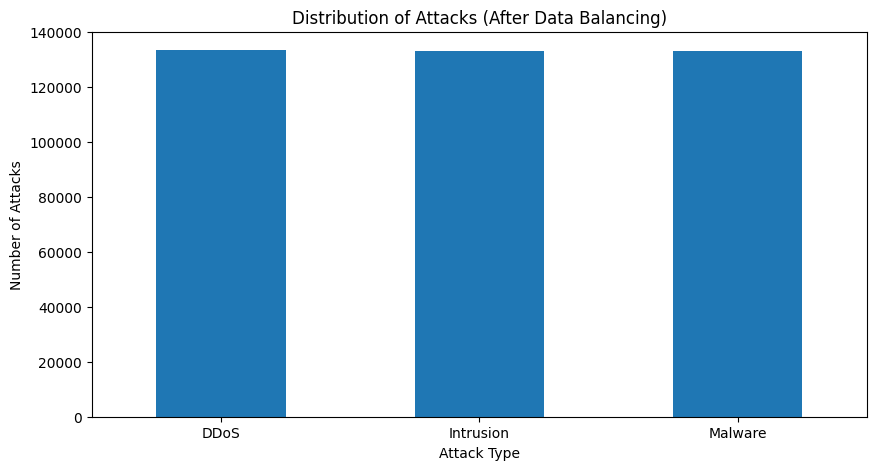

In [38]:

X_augmented = pd.concat([X_res, X_res_noisy], ignore_index=True)
y_augmented = pd.concat([y_res, y_res], ignore_index=True)


df_resampled = X_augmented.copy()
df_resampled['Attack Type'] = y_augmented

df_resampled.info()

print("Number of Attack Classes:", df_resampled['Attack Type'].unique())
print("\nNumber of Samples for each Attack Class:")
print(df_resampled['Attack Type'].value_counts())

plt.figure(figsize=(10, 5))
df_resampled['Attack Type'].value_counts().plot(kind='bar')
plt.xticks([0, 1, 2], ['DDoS', 'Intrusion', 'Malware'], rotation=0)
plt.ylabel('Number of Attacks')
plt.title("Distribution of Attacks (After Data Balancing)")
plt.show()


In [42]:

X_train, X_test, y_train, y_test = train_test_split(
    df_resampled.drop(columns=['Attack Type']),
    df_resampled['Attack Type'],
    test_size=0.2,  
    random_state=42
)

print("After Splitting the Dataset:")
print("Dimensions of TRAINING SET: ", X_train.shape, y_train.shape)
print("Dimensions of TESTING SET: ", X_test.shape, y_test.shape)

print("\nFirst 2 rows of TRAINING FEATURES (X_train):")
print(X_train.head(2))

print("\nFirst 2 rows of TRAINING TARGETS (y_train):")
print(y_train.head(2))

print("\nFirst 2 rows of TESTING FEATURES (X_test):")
print(X_test.head(2))

print("\nFirst 2 rows of TESTING TARGETS (y_test):")
print(y_test.head(2))


After Splitting the Dataset:
Dimensions of TRAINING SET:  (319998, 22) (319998,)
Dimensions of TESTING SET:  (80000, 22) (80000,)

First 2 rows of TRAINING FEATURES (X_train):
           Timestamp  Source IP Address  Destination IP Address   Source Port  \
63504   1.590621e+09       2.470071e+09            3.689676e+09  18026.000000   
208337  1.595381e+09       1.286472e+09            2.456478e+09   3038.000928   

        Destination Port  Protocol  Packet Length  Packet Type  Traffic Type  \
63504        9930.000000  0.000000     955.000000     0.000000      0.000000   
208337      21018.996815  0.977778    1458.999874     0.003032      0.999179   

        Payload Data  ...  Alerts/Warnings  Attack Signature  Action Taken  \
63504    9971.000000  ...         0.000000          0.000000      1.000000   
208337  24755.007937  ...         0.009925         -0.032631      2.006145   

        Severity Level  User Information  Device Information  Network Segment  \
63504         0.000000 

In [43]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print("After Feature Scaling,\nDimensions of TRAINING SET: ", X_train.shape,y_train.shape)
print("Dimensions of TESTING SET: ", X_test.shape,y_test.shape)


After Feature Scaling,
Dimensions of TRAINING SET:  (319998, 22) (319998, 3)
Dimensions of TESTING SET:  (80000, 22) (80000, 3)
